<a href="https://colab.research.google.com/github/rony260699/Machine_Learning/blob/main/Copy_of_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core
!pip install numpy pandas matplotlib seaborn scikit-learn joblib

# Data & finance
!pip install yfinance

# Statistical models
!pip install pmdarima statsmodels

# Prophet (Meta) — follow official install if you hit build issues.
!pip install prophet

# Deep learning (TensorFlow includes Keras)
!pip install tensorflow

# Hugging Face + deployment UI
!pip install huggingface_hub gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.3 MB/s eta 0:00:00


--- 1. Acquiring Data for TSLA ---


[*********************100%***********************]  1 of 1 completed


Total Samples: 2014
Train Samples: 1611
Test Samples: 403


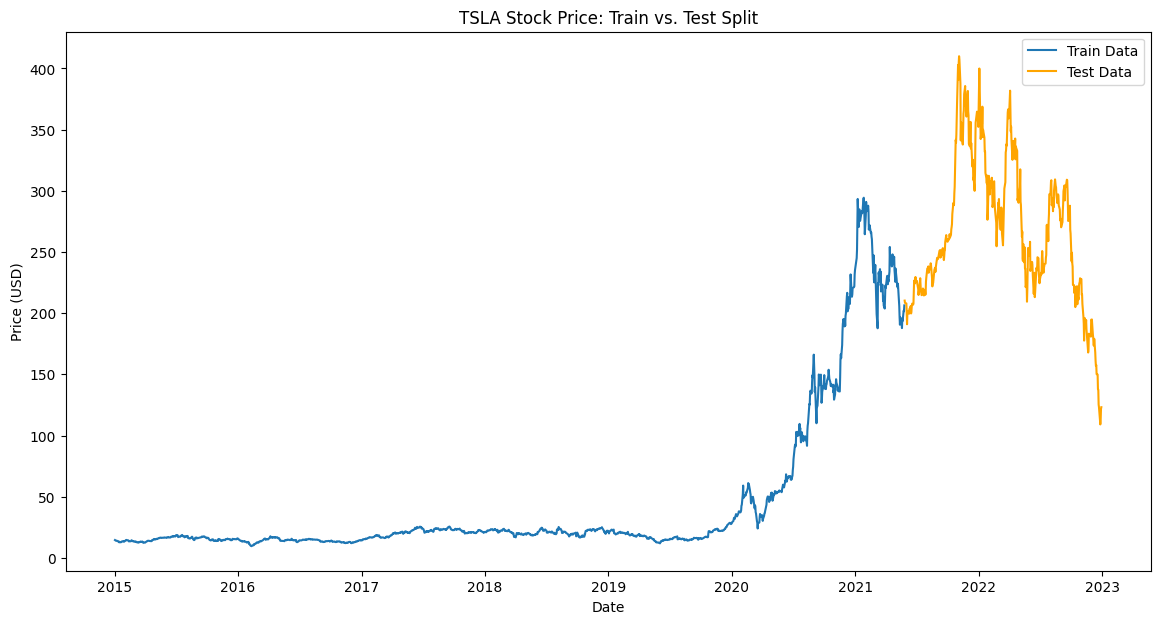

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Data Acquisition
import yfinance as yf

# Preprocessing and Modeling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


TICKER = 'TSLA'
START_DATE = '2015-01-01'
END_DATE = '2023-01-01'
TEST_SPLIT = 0.2
LOOK_BACK = 60

# Data Acquisition and Initial Processing
print(f"--- 1. Acquiring Data for {TICKER} ---")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

data = df['Close'].values.reshape(-1, 1)

# Split data into training and testing sets
train_size = int(len(data) * (1 - TEST_SPLIT))
train_data = data[:train_size]
test_data = data[train_size:]
test_dates = df.index[train_size:]

print(f"Total Samples: {len(data)}")
print(f"Train Samples: {len(train_data)}")
print(f"Test Samples: {len(test_data)}")

# Data for visualization
data_dates = df.index

plt.figure(figsize=(14, 7))
plt.plot(data_dates[:train_size], train_data, label='Train Data')
plt.plot(data_dates[train_size:], test_data, label='Test Data', color='orange')
plt.title(f'{TICKER} Stock Price: Train vs. Test Split')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [ ]:
df.to_csv('tesla.csv' , index=True)

In [ ]:
# --- 2. ARIMA Model Implementation ---

print("\n--- 2. Building ARIMA Model ---")


result = adfuller(train_data)
p_value = result[1]
print(f"ADF p-value on training data: {p_value:.4f}")

# If p-value > 0.05, the data is non-stationary, and differencing is needed (d > 0).


arima_order = (5, 1, 0) # Example default order (p=5, d=1, q=0)
print(f"Using default ARIMA order: {arima_order}")


# Rolling Window Forecasting for ARIMA
arima_predictions = []
history = [x for x in train_data]

print("Starting ARIMA Rolling Window Forecasting...")

# Loop through the test set
for t in range(len(test_data)):
    # Fit the ARIMA model on the current history
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()

    # Forecast the next point (out-of-sample prediction)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    arima_predictions.append(yhat)

    # Get the actual value and update history for the next iteration
    obs = test_data[t][0]
    # Append the actual value as a list to maintain consistent shape
    history.append([obs])

print("ARIMA Forecasting complete.")

# Convert predictions to numpy array
arima_predictions = np.array(arima_predictions).reshape(-1, 1)


--- 2. Building ARIMA Model ---
ADF p-value on training data: 0.9632
Using default ARIMA order: (5, 1, 0)
Starting ARIMA Rolling Window Forecasting...
ARIMA Forecasting complete.


In [ ]:
# --- 3. LSTM Model Implementation ---

print("\n--- 3. Building LSTM Model ---")

# Step 3.1: Scale and Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Resplit the scaled data
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

# Function to create sequence data (X, y)
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, LOOK_BACK)
X_test, y_test = create_sequences(test_scaled, LOOK_BACK)

# Reshape X for LSTM input: [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")

#  Build the LSTM Network
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(LOOK_BACK, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print("LSTM Model Summary:")
lstm_model.summary()

#  Train the Model
print("Training LSTM model...")
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)
print("LSTM Training complete.")

#  Forecasting (Rolling Window adapted for LSTM)


lstm_test_input = scaled_data[train_size - LOOK_BACK:]
lstm_test_input = lstm_test_input.reshape(1, -1)

lstm_predictions = []
current_batch = lstm_test_input[:, -LOOK_BACK:].reshape(1, LOOK_BACK, 1)

# Loop through the length of the test data (minus the look_back setup)
for i in range(len(test_data)):
    # Predict the next point
    predicted_scaled_price = lstm_model.predict(current_batch, verbose=0)[0]
    lstm_predictions.append(predicted_scaled_price)

    # Use the *actual* scaled value (for a rigorous rolling window) to update the input batch
    # This prevents the accumulation of error.
    next_scaled_point = test_scaled[i]

    # Update the input batch (remove first element, append the new actual value)
    current_batch = np.append(current_batch[:, 1:, :], [[next_scaled_point]], axis=1)

# Step 3.5: Inverse Transform LSTM predictions
lstm_predictions = np.array(lstm_predictions).reshape(-1, 1)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Adjust test dates/data length to match LSTM predictions (due to LOOK_BACK slicing)
# The first LOOK_BACK days of the test set are used to form the initial sequence,
# so the actual comparison starts later.
arima_comparison_data = test_data
lstm_comparison_data = test_data

arima_comparison_dates = test_dates
lstm_comparison_dates = test_dates


--- 3. Building LSTM Model ---
X_train shape: (1551, 60, 1)
LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
LSTM Training complete.


ARIMA - RMSE: 10.6366, MAPE: 2.83%
LSTM - RMSE: 17.7897, MAPE: 5.28%

--- Performance Comparison Table ---
| Metric   |   ARIMA |    LSTM |
|:---------|--------:|--------:|
| RMSE     | 10.6366 | 17.7897 |
| MAPE (%) |  2.83   |  5.28   |


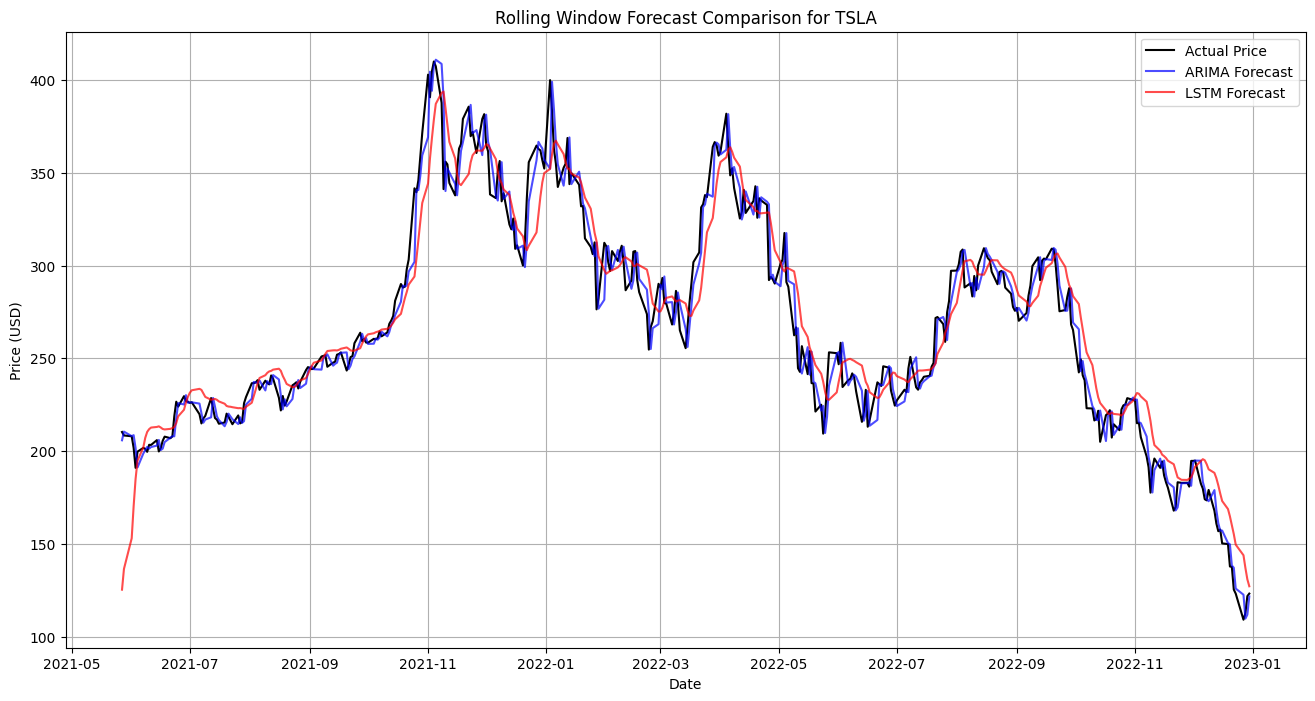

In [ ]:
# --- 4. Evaluation and Comparison ---

y_true_arima = test_data.flatten()
y_pred_arima = arima_predictions.flatten()


y_true_lstm = test_data.flatten()
y_pred_lstm = lstm_predictions.flatten()

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"{model_name} - RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    return {'RMSE': rmse, 'MAPE': mape}

# ARIMA Metrics
arima_metrics = calculate_metrics(y_true_arima, y_pred_arima, "ARIMA")

# LSTM Metrics
lstm_metrics = calculate_metrics(y_true_lstm, y_pred_lstm, "LSTM")


comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAPE (%)'],
    'ARIMA': [f"{arima_metrics['RMSE']:.4f}", f"{arima_metrics['MAPE']:.2f}"],
    'LSTM': [f"{lstm_metrics['RMSE']:.4f}", f"{lstm_metrics['MAPE']:.2f}"]
})

print("\n--- Performance Comparison Table ---")
print(comparison_df.to_markdown(index=False))


plt.figure(figsize=(16, 8))
plt.plot(arima_comparison_dates, arima_comparison_data, label='Actual Price', color='black')
plt.plot(arima_comparison_dates, y_pred_arima, label='ARIMA Forecast', color='blue', alpha=0.7)
plt.plot(lstm_comparison_dates, y_pred_lstm, label='LSTM Forecast', color='red', alpha=0.7)
plt.title(f'Rolling Window Forecast Comparison for {TICKER}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import joblib
from tensorflow.keras.models import Sequential
# Note: In a continuous notebook environment, 'lstm_model' and 'scaler'
# would be available from the previous execution block (Step 3).

# --- Saving Model Artifacts for Deployment ---

# 1. Save the Keras model
# We use the HDF5 format (.h5) for compatibility.
try:
    # Ensure lstm_model is defined (as it is in the user's provided code)
    if 'lstm_model' in locals():
        lstm_model.save('best_lstm_model.h5')
        print("LSTM model saved successfully as best_lstm_model.h5")
    else:
        print("Error: 'lstm_model' is not defined. Ensure model training was run.")
except Exception as e:
    print(f"Error saving model: {e}")

# 2. Save the MinMaxScaler object
try:
    # Ensure scaler is defined (as it is in the user's provided code)
    if 'scaler' in locals():
        joblib.dump(scaler, 'scaler.pkl')
        print("Scaler object saved successfully as scaler.pkl")
    else:
        print("Error: 'scaler' is not defined. Ensure data scaling was run.")
except Exception as e:
    print(f"Error saving scaler: {e}")

LSTM model saved successfully as best_lstm_model.h5
Scaler object saved successfully as scaler.pkl


In [ ]:
import joblib
from tensorflow.keras.models import Sequential
# Assuming 'lstm_model' and 'scaler' variables are available from training

# --- Saving Model Artifacts for Deployment (Using Recommended .keras format) ---

# 1. Save the Keras model
MODEL_FILENAME = 'best_lstm_model.keras'
try:
    # Use the recommended .keras format
    if 'lstm_model' in locals():
        lstm_model.save(MODEL_FILENAME)
        print(f"LSTM model saved successfully as {MODEL_FILENAME}")
    else:
        print("Error: 'lstm_model' is not defined. Ensure model training was run.")
except Exception as e:
    print(f"Error saving model: {e}")

# 2. Save the MinMaxScaler object
SCALER_FILENAME = 'scaler.pkl'
try:
    if 'scaler' in locals():
        joblib.dump(scaler, SCALER_FILENAME)
        print(f"Scaler object saved successfully as {SCALER_FILENAME}")
    else:
        print("Error: 'scaler' is not defined. Ensure data scaling was run.")
except Exception as e:
    print(f"Error saving scaler: {e}")

LSTM model saved successfully as best_lstm_model.keras
Scaler object saved successfully as scaler.pkl
